In [1]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
rng = np.random.default_rng(2205)
random.seed(2205)

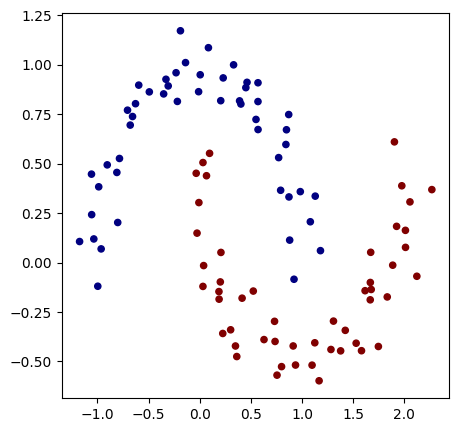

In [3]:
X, y = make_moons(n_samples = 100, noise = 0.1, random_state = 42)

y = y * 2 - 1 # Convert to -1 and 1 labels

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
model = MLP(2, [16, 16, 1])
print(model)
print(len(model.parameters()))

MLP[Layer[ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer[ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer[LinearNeuron(16)]]
337


In [5]:
def loss_fn(
    model: MLP,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int | None = None,
) -> tuple[Value, float]:
    """Compute the loss for a given model and dataset."""

    if batch_size is None:
        Xb, yb = X, y
    else:
        indices: int = rng.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[indices], y[indices]

    inputs = [list(map(Value, x)) for x in Xb]

    # forward pass
    outputs = list(map(model, inputs))

    # copy Karpathy's loss function
    # svm max-margin loss
    losses: list[Value] = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, outputs)]
    data_loss: Value = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha: float = 1e-4
    reg_loss: Value = alpha * sum(p * p for p in model.parameters())
    total_loss: Value = data_loss + reg_loss

    # also get accuracy
    accuracy: float = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, outputs, strict = True)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss_fn(model, X, y)
print(total_loss, acc)

Value(value=2.19319, grad=0.00000, label='') 0.5


In [6]:
for epoch in range(100):
    # forward
    total_loss, acc = loss_fn(model, X, y)

    # backward
    model.zero_grad()
    total_loss.backward()

    # sgd
    learning_rate: float = 1.0 - 0.9 * epoch / 100.0

    for p in model.parameters():
        p.data += -learning_rate * p.grad

    print(f'Epoch {epoch}, Loss: {total_loss.data:.4f}, Accuracy: {acc:.4f}')

Epoch 0, Loss: 2.1932, Accuracy: 0.5000
Epoch 1, Loss: 1.8063, Accuracy: 0.5000
Epoch 2, Loss: 0.8334, Accuracy: 0.6000
Epoch 3, Loss: 0.3624, Accuracy: 0.8600
Epoch 4, Loss: 0.3674, Accuracy: 0.8300
Epoch 5, Loss: 0.2866, Accuracy: 0.8900
Epoch 6, Loss: 0.2722, Accuracy: 0.9000
Epoch 7, Loss: 0.2633, Accuracy: 0.8900
Epoch 8, Loss: 0.2670, Accuracy: 0.9000
Epoch 9, Loss: 0.2626, Accuracy: 0.9000
Epoch 10, Loss: 0.2548, Accuracy: 0.9000
Epoch 11, Loss: 0.2389, Accuracy: 0.9000
Epoch 12, Loss: 0.2406, Accuracy: 0.9000
Epoch 13, Loss: 0.2216, Accuracy: 0.9100
Epoch 14, Loss: 0.2182, Accuracy: 0.9100
Epoch 15, Loss: 0.2046, Accuracy: 0.9200
Epoch 16, Loss: 0.2009, Accuracy: 0.9200
Epoch 17, Loss: 0.1891, Accuracy: 0.9300
Epoch 18, Loss: 0.1969, Accuracy: 0.9200
Epoch 19, Loss: 0.1901, Accuracy: 0.9300
Epoch 20, Loss: 0.2262, Accuracy: 0.9000
Epoch 21, Loss: 0.2187, Accuracy: 0.9200
Epoch 22, Loss: 0.3723, Accuracy: 0.8300
Epoch 23, Loss: 0.1833, Accuracy: 0.9200
Epoch 24, Loss: 0.1671, Ac

(-1.5978882018302847, 2.1521117981697153)

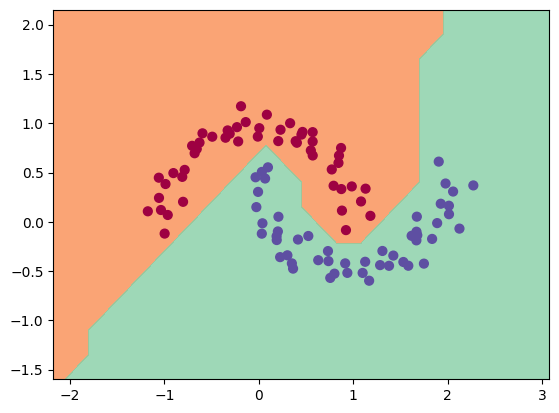

In [7]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [ ]:
total_loss.draw_graph()